Test of low rank on single image

In [ ]:
import cv2

img = cv2.imread('/content/Feels_good_man.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

cv2.imwrite('/content/Feels_good_man_GSI.jpg', gray_img,)

True

In [ ]:
import cv2

im = cv2.imread('/content/Feels_good_man_GSI.jpg')

In [ ]:
import numpy as np
print(type(im))
im =np.mean(img, axis=2).astype(np.uint8)
print(im.shape)
print(type(im.shape))

<class 'numpy.ndarray'>
(320, 312)
<class 'tuple'>


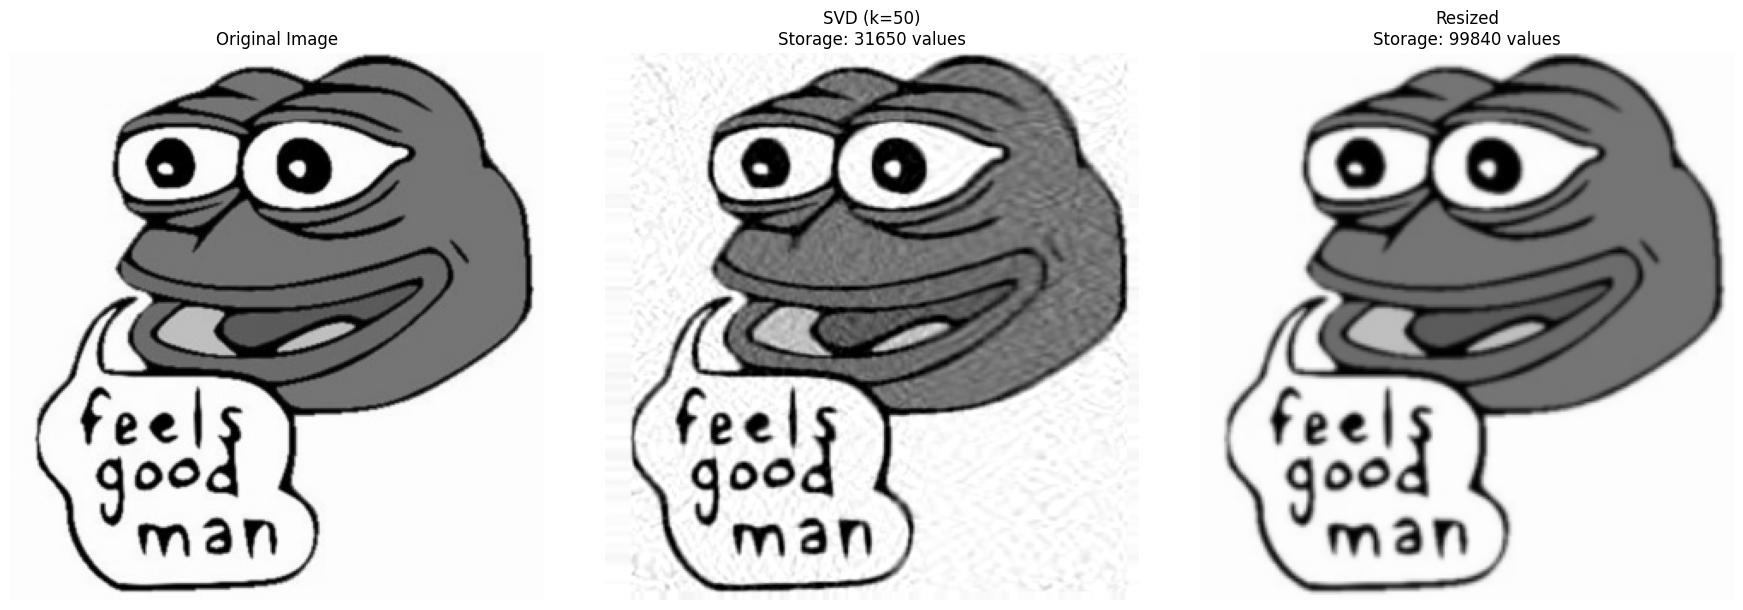


Comparison Metrics:
Original size: 99840 pixels
SVD storage: 31650 values (31.7% of original)
Resized storage: 99840 values (100.0% of original)

Mean Squared Error (Lower is better):
SVD MSE: 112.13
Resized MSE: 188.40

Compression Ratios:
SVD compression: 3.2x
Resized compression: 1.0x


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

def low_rank_approximation(image_path, k):
    # Load image
    img = Image.open(image_path)
    if img.mode != 'L':
        img = img.convert('L')  # Convert to grayscale
    original = np.array(img, dtype=np.float64)

    # Perform SVD
    U, S, Vt = np.linalg.svd(original, full_matrices=False)

    # Keep only top k singular values
    S_k = np.diag(S[:k])
    U_k = U[:, :k]
    Vt_k = Vt[:k, :]

    # Reconstruct the image
    reconstructed = U_k @ S_k @ Vt_k
    reconstructed = np.clip(reconstructed, 0, 255).astype(np.uint8)

    return original, reconstructed, S

def calculate_resized_image(original, k):
    """Calculate resized image with same storage as SVD compression"""
    h, w = original.shape
    svd_storage = k * (h + w + 1)

    # Calculate new dimensions maintaining aspect ratio
    aspect_ratio = w / h
    new_h = int(math.sqrt(svd_storage / aspect_ratio))
    new_w = int(svd_storage / new_h)

    # Resize using PIL
    resized = Image.fromarray(original.astype(np.uint8)).resize((new_w, new_h), Image.BILINEAR)
    resized = np.array(resized)

    # Resize back to original dimensions for comparison
    resized_back = Image.fromarray(resized).resize((w, h), Image.BILINEAR)
    return np.array(resized_back)

def plot_comparison(original, svd_recon, resized, k):
    plt.figure(figsize=(18, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray', vmin=0, vmax=255)
    plt.title('Original Image')
    plt.axis('off')

    # SVD reconstruction
    plt.subplot(1, 3, 2)
    plt.imshow(svd_recon, cmap='gray', vmin=0, vmax=255)
    plt.title(f'SVD (k={k})\nStorage: {k*(original.shape[0]+original.shape[1]+1)} values')
    plt.axis('off')

    # Resized image
    plt.subplot(1, 3, 3)
    plt.imshow(resized, cmap='gray', vmin=0, vmax=255)
    plt.title(f'Resized\nStorage: {resized.shape[0]*resized.shape[1]} values')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def calculate_mse(img1, img2):
    """Calculate Mean Squared Error between two images"""
    return np.mean((img1.astype(float) - img2.astype(float))**2)

# Example usage
image_path = '/content/Feels_good_man_GSI.jpg'
k = 50  # Number of singular values to keep

# Get SVD approximation
original, svd_recon, singular_values = low_rank_approximation(image_path, k)

# Get resized version with equivalent storage
resized = calculate_resized_image(original, k)

# Plot comparison
plot_comparison(original, svd_recon, resized, k)

# Calculate metrics
original_size = original.shape[0] * original.shape[1]
svd_size = k * (original.shape[0] + original.shape[1] + 1)
resized_size = resized.shape[0] * resized.shape[1]  # Should be ≈ svd_size

print("\nComparison Metrics:")
print(f"Original size: {original_size} pixels")
print(f"SVD storage: {svd_size} values ({svd_size/original_size:.1%} of original)")
print(f"Resized storage: {resized_size} values ({resized_size/original_size:.1%} of original)")
print(f"\nMean Squared Error (Lower is better):")
print(f"SVD MSE: {calculate_mse(original, svd_recon):.2f}")
print(f"Resized MSE: {calculate_mse(original, resized):.2f}")
print(f"\nCompression Ratios:")
print(f"SVD compression: {original_size/svd_size:.1f}x")
print(f"Resized compression: {original_size/resized_size:.1f}x")

convolution example

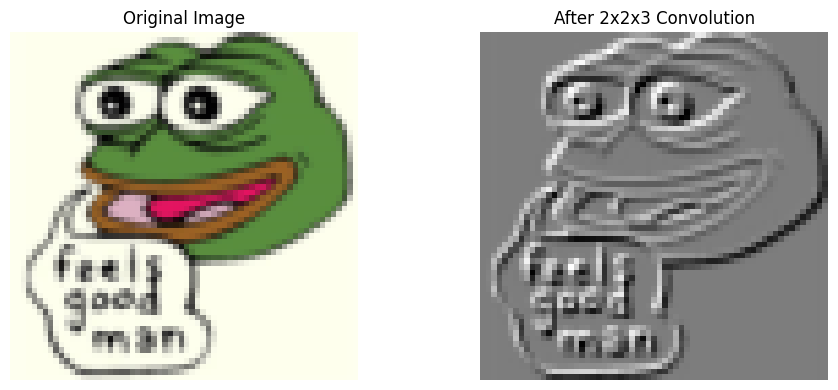

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

# 1. Load and preprocess the image
img_path = "/content/Feels_good_man.jpg"  # Replace with your image path
img = Image.open(img_path).convert("RGB")

# Resize for easy visualization
transform = T.Compose([
    T.Resize((64, 64)),  # Keep it small
    T.ToTensor()         # Converts to tensor of shape (3, H, W)
])
img_tensor = transform(img).unsqueeze(0)  # Shape: (1, 3, 64, 64)

# 2. Define a 2x2x3 filter manually
# The shape should be (out_channels, in_channels, kernel_height, kernel_width)
# out_channels = 1 (single output channel)
# in_channels = 3 (from the input image)
# kernel_height = 2
# kernel_width = 2
filter = torch.tensor([
    [  # This represents the single output channel
        [  # Red channel part of the filter
            [1., 0.],
            [0., -1.]
        ],
        [  # Green channel part of the filter
            [0., 1.],
            [-1., 0.]
        ],
        [  # Blue channel part of the filter
            [1., -1.],
            [1., -1.]
        ],
    ]
], dtype=torch.float32)
# Now the shape is (1, 3, 2, 2), which is correct for F.conv2d
# filter = filter.unsqueeze(0)

# 3. Apply convolution
output = F.conv2d(img_tensor, filter, bias=None, stride=[1,1], padding=0)

# 4. Display original image and convolution output
def show_tensor_image(tensor, title):
    # tensor shape: (1, 1, H, W) or (1, 3, H, W)
    img = tensor.squeeze(0)  # remove batch
    if img.shape[0] == 1:
        plt.imshow(img.squeeze(0).detach().numpy(), cmap="gray")
    else:

        img = img.permute(1, 2, 0).detach().numpy()
        # plt.imshow(img.squeeze(2), cmap='gray')
        plt.imshow(img, cmap='gray') # Use the standard imshow

    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
show_tensor_image(img_tensor, "Original Image")

plt.subplot(1, 2, 2)
show_tensor_image(output, "After 2x2x3 Convolution")
plt.tight_layout()
plt.show()

In [ ]:
!pip install tensorly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 94.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
# np.random.normal(3, 2.5, size=(256, 312))
print(np.random.normal(3, 2.5, size=(256, 312)))

[[ 2.72882077  2.60968845  4.85435404 ...  3.04265524  0.87595391
   6.2431421 ]
 [ 5.63784705  5.39199407  2.18463515 ...  2.07394575  7.4138914
   4.02420206]
 [ 2.57757488  5.52940558  8.42605233 ...  2.17331379  3.10423209
   1.99389236]
 ...
 [-1.98652881 -1.42950986 -0.63653141 ...  5.79146256 -0.65922185
   2.54248438]
 [ 7.82613008  0.29181902  6.78996161 ...  5.22216044  8.04100536
   3.36750696]
 [ 1.66366923  3.65575292  8.46316405 ... -0.72011911  7.08242233
  -1.99599391]]


In [ ]:
import numpy as np
from PIL import Image
img = np.array(Image.open("/content/Feels_good_man_GSI.jpg"))
I = img
m = 256
n = I.shape[0]
G = np.random.randn(m, n)

R = G @ I
result_img = (R - R.min()) / (R.max() - R.min())
Image.fromarray((result_img * 255).astype(np.uint8)).save("output.jpg")

Tucker decomposition

In [ ]:
import numpy as np
from scipy.linalg import svd
def tucker_decompose(kernel_4d, rank_s, rank_t):
  d1, d2, S, T = kernel_4d.shape
  D = d1 * d2
  kernel_flat = kernel_4d.reshape(D, S * T)
  U, S_svd, VT = np.linalg.svd(kernel_flat, full_matrices=False)
  U_r = U[:, :rank_s * rank_t]        # (D x r)
  S_r = np.diag(S_svd[:rank_s * rank_t])  # (r x r)
  VT_r = VT[:rank_s * rank_t, :]      # (r x S*T)
  V_tensor = VT_r.reshape(rank_s * rank_t, S, T)
  V_avg = np.mean(V_tensor, axis=0)
  U_s, S_, Vt_t = np.linalg.svd(V_avg, full_matrices=False)
  P_s = U_s[:, :rank_s]
  P_t = Vt_t[:rank_t, :].T
  G = np.zeros((d1, d2, rank_s, rank_t))
  for i in range(d1):
        for j in range(d2):
            patch = kernel_4d[i, j, :, :]  # shape (S x T)
            G[i, j] = P_s.T @ patch @ P_t  # shape (R_s x R_t)

  return G, P_s, P_t

In [ ]:
K = np.zeros((2, 2, 2, 2))
K[:, :, 0, 0] = [[0, 1], [2, 3]]
K[:, :, 0, 1] = [[4, 5], [6, 7]]
K[:, :, 1, 0] = [[3, 4], [5, 6]]
K[:, :, 1, 1] = [[7, 8], [9, 10]]
G, P_s, P_t = tucker_decompose(K, rank_s=1, rank_t=1)
print("Core G shape:", G.shape)
print("P_s shape:", P_s.shape)
print("P_t shape:", P_t.shape)

Core G shape: (2, 2, 1, 1)
P_s shape: (2, 1)
P_t shape: (2, 1)


In [ ]:
def reconstruct_kernel_from_tucker(G, P_s, P_t):
  K_hat = np.einsum('ijrs,sr,tr->ijst', G, P_s, P_t)
  return K_hat

In [ ]:
def reconstruct_kernel(G, P_s, P_t):
    temp = np.tensordot(G, P_s, axes=([2], [1]))  # Shape: (d, d, R_t, S)
    K_hat = np.tensordot(temp, P_t, axes=([2], [1]))  # Shape: (d, d, S, T)
    return np.transpose(K_hat, (0, 1, 2, 3))  # Ensure order is (d, d, S, T)

In [ ]:
k_Cap=reconstruct_kernel(G,P_s, P_t)

In [ ]:
print(k_Cap)

[[[[ 1.83374397  3.88162096]
   [ 3.07887823  6.51728838]]

  [[ 2.23266097  4.72603796]
   [ 3.74866468  7.93507469]]]


 [[[ 2.63157797  5.57045495]
   [ 4.41845112  9.35286101]]

  [[ 3.03049496  6.41487195]
   [ 5.08823757 10.77064732]]]]


In [ ]:
numerator = np.linalg.norm(K - k_Cap)
denominator = np.linalg.norm(K)
norm=numerator/denominator
print(norm)

0.1247488115133621


In [ ]:
!pip install --upgrade torch torchvision torchaudio -f https://download.pytorch.org/whl/cu118/torch_whl.html

Looking in links: https://download.pytorch.org/whl/cu118/torch_whl.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8

VIT Vision Transformer:

1.   first function sketching techniques
2.   second attention mechanism



In [ ]:
def gauss_sketch(x, sketch_size,d):
    sketch = np.random.normal(loc=0.0, scale=1/np.sqrt(d), size=(sketch_size,d))
    return x @ sketch.transpose


In [ ]:
import numpy as np
sketch = np.random.normal(loc=0.0, scale=1/np.sqrt(32), size=(64,32))
sketch.shape

(64, 32)

In [ ]:
def gauss_sketch(x: torch.Tensor, sketch_size: int) -> torch.Tensor:
    B, N, d = x.shape
    sketch = torch.randn(sketch_size, d, device=x.device) / d**0.5
    return torch.matmul(x, sketch.T)  # (B, N, sketch_size)


In [ ]:
import torch
import numpy as np
import os
def gauss_sketch_matrix_file(sketch_size: int, d: int,n) -> torch.Tensor:
    for i in range(n):
      sketch = np.random.normal(loc=0.0, scale=1/np.sqrt(d), size=(sketch_size,d))
      filepath=f"/content/gauss_matrix_all/gauss_sketch_matrix{i}.pt"
      if not os.path.exists(os.path.dirname(filepath)):
        os.makedirs(os.path.dirname(filepath))
      torch.save(sketch, filepath)
    return torch.load(filepath, weights_only=False), print("all sketched matrix saved in file")

In [ ]:
a=nn.Linear(64,64, bias=False)
torch.save(a.weight.data.clone(), "/content/a.pt")

In [ ]:
import torch
import time
tensor = torch.randn(1024, 128)
b=nn.Linear(128,32, bias=False)
start_time = time.time()
for _ in range(1000):


    # b=b.weight.data.copy_(tensor.T)
    c=b(tensor)
total_time = time.time() - start_time


print(f"Time to load 1000 times: {total_time*1000:.4f} ms")
print(f"Average per load: {total_time * 1000 / 1000:.4f} ms")

Time to load 1000 times: 149.6847 ms
Average per load: 0.1497 ms


In [ ]:
import time
tensor__ = torch.randn(64, 64)
d=torch.randn(32,64)
start_time = time.time()

for _ in range(1000):


    # b=b.weight.data.copy_(tensor.T)
    f=tensor__@d.T
total_time = time.time() - start_time
print(f"Time to load 1000 times: {total_time*1000:.4f} ms")
print(f"Average per load: {total_time * 1000 / 1000:.4f} ms")
# print(b.weight.data.T.shape)

Time to load 1000 times: 12.3165 ms
Average per load: 0.0123 ms


In [ ]:
b=torch.randn(32,64)
tensor = torch.randn(256, 64)
start_time = time.time()
for _ in range(1000):


    # b=b.weight.data.copy_(tensor.T)
    c=tensor@b.T
total_time = time.time() - start_time
print(f"Time to load 1000 times: {total_time*1000:.4f} ms")
print(f"Average per load: {total_time * 1000 / 1000:.4f} ms")
# print(b.weight.data.T.shape)

Time to load 1000 times: 27.1571 ms
Average per load: 0.0272 ms


In [ ]:
import torch
import time
file_path = "/content/a.pt"
start_time = time.time()
for _ in range(1000):
    tensor_1 = torch.load(file_path,weights_only=False)
    b = nn.Linear(64, 64, bias=False)
    b.weight.data.copy_(tensor_1.T) # Corrected line
    c = b(tensor_1)
total_time = time.time() - start_time


print(f"Time to load 1000 times: {total_time:.4f} sec")
print(f"Average per load: {total_time * 1000 / 1000:.4f} ms")

Time to load 1000 times: 0.5489 sec
Average per load: 0.5489 ms


In [ ]:
gauss_sketch_matrix_file(32,64,5)

all sketched matrix saved in file


(array([[-0.08746063,  0.00051671,  0.08004319, ...,  0.03052914,
          0.05672063,  0.0830617 ],
        [ 0.01808968,  0.06110271, -0.00359143, ..., -0.18587083,
          0.11184821,  0.14096439],
        [ 0.02752458, -0.05696442, -0.24820791, ..., -0.02859828,
          0.18558162, -0.12333904],
        ...,
        [ 0.32779627, -0.11502386, -0.14792494, ...,  0.08150108,
         -0.01173206, -0.1264156 ],
        [-0.26210805, -0.05624849,  0.06323996, ...,  0.07041746,
          0.10881528, -0.07219166],
        [-0.0825855 ,  0.2698388 ,  0.13973436, ..., -0.12955392,
         -0.15522375,  0.03152199]]),
 None)

In [ ]:
a=torch.load("/content/gauss_matrix_all/gauss_sketch_matrix0.pt", weights_only=False)
a.shape

(32, 64)

In [ ]:
for i in range(5):
  print(f"/content/gauss_matrix_all/gauss_sketch_matrix{i}.pt")
  print(f"This is matrix {i}: \n{torch.load(f'/content/gauss_matrix_all/gauss_sketch_matrix{i}.pt', weights_only=False)}")

/content/gauss_matrix_all/gauss_sketch_matrix0.pt
This is matrix 0: 
[[ 0.057339    0.00617853 -0.00493804 ... -0.21281597  0.01229976
  -0.03481906]
 [ 0.34597226  0.08557563  0.195638   ...  0.00365809 -0.37532849
  -0.06070739]
 [-0.0271962  -0.01524702  0.02851692 ...  0.212743    0.32549605
  -0.03789469]
 ...
 [-0.04624622  0.07004364  0.09251348 ...  0.02590311  0.03684349
   0.01501556]
 [-0.21827853 -0.05358303  0.01836182 ... -0.01146883  0.2524766
   0.30079997]
 [ 0.04239267  0.26996273 -0.09594759 ... -0.03529278 -0.02394963
   0.02430149]]
/content/gauss_matrix_all/gauss_sketch_matrix1.pt
This is matrix 1: 
[[-0.13317173 -0.08455241  0.02447618 ...  0.18566467 -0.1458847
   0.01633071]
 [ 0.06198835 -0.12110304 -0.05364056 ...  0.03071778 -0.16790785
   0.04861857]
 [ 0.07476458 -0.06640073 -0.00382817 ... -0.023416   -0.0924947
   0.26403818]
 ...
 [-0.17838474 -0.01258951  0.04063772 ... -0.0489791   0.01118759
   0.17233987]
 [ 0.0630953   0.00907461  0.01793448 ... -0

In [ ]:
# def count_sketch(x: torch.Tensor, sketch_size: int) -> torch.Tensor:
#     B, N, d = x.shape
#     device = x.device

#     # 1. Random sign-flip vector: +1 or -1
#     sign = torch.randint(0, 2, (d,), device=device) * 2 - 1  # (d,) in {-1, +1}

#     # 2. Random bucket assignment for each feature
#     bucket = torch.randint(0, sketch_size, (d,), device=device)  # (d,)

#     # 3. Initialize sketch matrix
#     sketch = torch.zeros(B, N, sketch_size, device=device)

#     # 4. Apply sketching
#     for i in range(d):
#         sketch[:, :, bucket[i]] += x[:, :, i] * sign[i]

#     return sketch  # (B, N, sketch_size)

In [ ]:
#optimized version best version of count sketch
def count_sketch(x: torch.Tensor, sketch_size: int, sign: torch.Tensor, bucket: torch.Tensor) -> torch.Tensor:
    B, N, d = x.shape
    x_signed = x * sign  # (B, N, d)
    sketch = torch.zeros(B, N, sketch_size, device=x.device)
    bucket_expanded = bucket.unsqueeze(0).unsqueeze(0).expand(B, N, d)
    sketch.scatter_add_(2, bucket_expanded, x_signed)
    return sketch

In [ ]:
# def phd_sketch(x: torch.Tensor, sketch_size: int) -> torch.Tensor:
#     B, N, d = x.shape
#     device = x.device
#     assert (d & (d - 1)) == 0, "d must be power of 2 for Hadamard"

#     # 1. Random sign-flip
#     D = torch.randint(0, 2, (d,), device=device) * 2 - 1  # (d,)
#     x = x * D  # (B, N, d)

#     # 2. Hadamard projection
#     from scipy.linalg import hadamard
#     H = hadamard(d).astype('float32')[:sketch_size] / (d ** 0.5)
#     H = torch.tensor(H, device=device)  # (sketch_size, d)

#     return torch.matmul(x, H.T)  # (B, N, sketch_size)


In [ ]:
import numpy as np
sketch = np.abs(np.random.normal(loc=0.0, scale=1/np.sqrt(4), size=(4,4)))
sketch

array([[0.35918266, 0.14178371, 0.5265273 , 0.3147038 ],
       [0.3349468 , 0.91914887, 0.56934874, 0.27238804],
       [0.22798782, 0.67030128, 0.36747789, 0.27542191],
       [0.36142275, 0.02251588, 0.25246339, 0.35858417]])

Patch Embedding layer

In [ ]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_ch=3, emb_dim=64):
        super().__init__()
        self.proj = nn.Conv2d(
            in_channels=in_ch,
            out_channels=emb_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        self.num_patches = (img_size // patch_size) ** 2

    def forward(self, x):
        # x: (B, 3, 32, 32)
        x = self.proj(x)                    # → (B, emb_dim, H', W') = (B, 64, 8, 8)
        x = x.flatten(2)                    # → (B, 64, 64) — flatten H' and W'
        x = x.transpose(1, 2)               # → (B, 64, 64) → (B, num_patches, emb_dim)
        return x


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
def load_and_preprocess_image(image_path):

  transform = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
  img = Image.open(image_path).convert('RGB')
  torch.stack([transform(img)])
  return transform(img).unsqueeze(0)

In [ ]:
patcher = PatchEmbedding()
dummy_img = torch.randn(2, 3, 32, 32)  # batch of 2 images

out = patcher(load_and_preprocess_image("/content/Feels_good_man.jpg"))
print(out.shape)  #  (1, 64, 64)
ok =patcher(dummy_img)
ok.shape # (2, 64, 64)

torch.Size([1, 64, 64])


torch.Size([2, 64, 64])

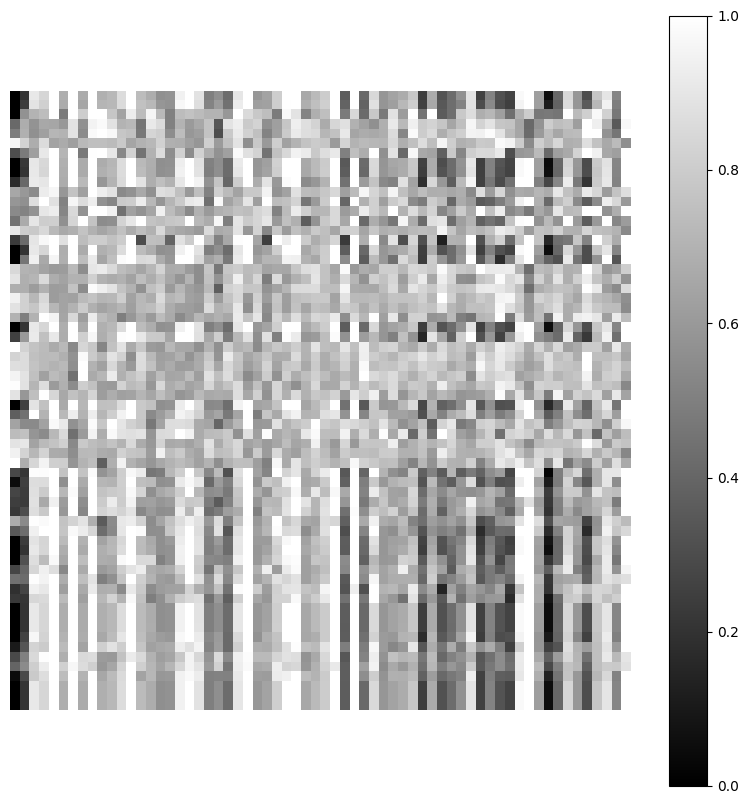

In [ ]:
import torch
import matplotlib.pyplot as plt
# out.numpy
out = out* 0.5 + 0.5
plt.figure(figsize=(10, 10))
plt.imshow(out.squeeze(0), cmap='gray', vmin=0, vmax=1)
plt.colorbar()
plt.axis('off')
plt.show()

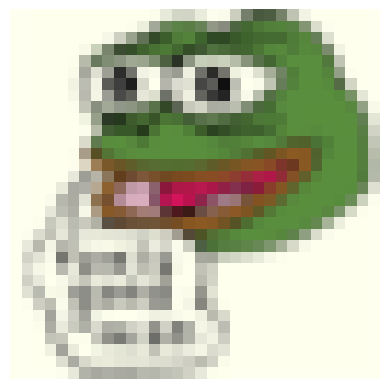

In [ ]:
import matplotlib.pyplot as plt

tensor = load_and_preprocess_image("/content/Feels_good_man.jpg")

# Denormalize for display
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    return tensor * std + mean

plt.imshow(denormalize(tensor)[0].permute(1, 2, 0))
plt.axis('off')
plt.show()

class token and position embedding

In [ ]:
class ViTWithPosition(nn.Module):
    def __init__(self, patch_embed, emb_dim=64, num_patches=64):
        super().__init__()
        self.patch_embed = patch_embed  # instance of PatchEmbedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))  # +1 for CLS

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)                      # (B, 64, 64)
        cls = self.cls_token.expand(B, -1, -1)       # (B, 1, 64)
        x = torch.cat([cls, x], dim=1)               # (B, 65, 64)
        x = x + self.pos_embed                       # add positional encoding
        return x


In [ ]:
patcher = PatchEmbedding()
vit_tokens = ViTWithPosition(patch_embed=patcher)

In [ ]:
dummy_img = torch.randn(2, 3, 32, 32)
out = vit_tokens(dummy_img)
print(out.shape)  # (2, 65, 64)


torch.Size([2, 65, 64])


In [ ]:
image_tensor = load_and_preprocess_image("/content/Feels_good_man.jpg")
token_based = vit_tokens(image_tensor)
print(token_based.shape)

torch.Size([1, 65, 64])


the Self-Attention Block (with Sketching)               

first one is single head attention.               
second one is multi head attention.

In [ ]:
# class SketchSelfAttention(nn.Module):
#     def __init__(self, dim=64, sketch_dim=32, use_sketch=True):
#         super().__init__()
#         self.use_sketch = use_sketch
#         self.dim = dim
#         self.r = sketch_dim
#         self.Wq = nn.Linear(dim, dim)
#         self.Wk = nn.Linear(dim, dim)
#         self.Wv = nn.Linear(dim, dim)
#         self.out_proj = nn.Linear(dim, dim)

#     def forward(self, x):
#         B, N, D = x.shape
#         q = self.Wq(x)
#         k = self.Wk(x)
#         v = self.Wv(x)

#         if self.use_sketch:
#             d = D
#             S_q = torch.randn(self.r, d, device=x.device) / d**0.5
#             S_k = torch.randn(self.r, d, device=x.device) / d**0.5
#             q = q @ S_q.T  # (B, N, r)
#             k = k @ S_k.T
#             scale = self.r ** -0.5
#         else:
#             scale = D ** -0.5  # full QK without sketch

#         attn = torch.softmax(q @ k.transpose(-2, -1) * scale, dim=-1)
#         out = attn @ v
#         return self.out_proj(out)


below sketch attention is where Wq and Wk sketched

In [ ]:
class SketchSelfAttention(nn.Module):
    def __init__(self, dim=64, sketch_dim=32, use_sketch=False,
                 train_mode=False, wq_path=None, wk_path=None,
                 s_q_path=None, s_k_path=None):
        super().__init__()
        self.dim = dim
        self.sketch_dim = sketch_dim
        self.use_sketch = use_sketch
        self.train_mode = train_mode

        self.Wv = nn.Linear(dim, dim)
        self.out_proj = nn.Linear(dim, dim)

        if use_sketch:
            if train_mode:
                assert s_q_path and s_k_path
                self.register_buffer("S_q", torch.tensor(torch.load(s_q_path, weights_only=False), dtype=torch.float32))
                self.register_buffer("S_k", torch.tensor(torch.load(s_k_path, weights_only=False), dtype=torch.float32))
                self.Wq = nn.Linear(dim, dim, bias=False)
                self.Wk = nn.Linear(dim, dim, bias=False)
            else:
                assert wq_path and wk_path
                Wq_sketch = torch.load(wq_path)  # (d, r)
                Wk_sketch = torch.load(wk_path)
                self.Wq = nn.Linear(dim, sketch_dim, bias=False)
                self.Wk = nn.Linear(dim, sketch_dim, bias=False)
                self.Wq.weight.data.copy_(Wq_sketch.T)
                self.Wk.weight.data.copy_(Wk_sketch.T)
        else:
            self.Wq = nn.Linear(dim, dim)
            self.Wk = nn.Linear(dim, dim)
    def forward(self, x):
        if self.use_sketch and self.train_mode:
            Wq_sketched = self.Wq.weight @ self.S_q.T  # (d, r)
            Wk_sketched = self.Wk.weight @ self.S_k.T

            q = x @ Wq_sketched  # (B, N, r)
            k = x @ Wk_sketched  # (B, N, r)
        else:
            q = self.Wq(x)
            k = self.Wk(x)

        v = self.Wv(x)
        scale = q.shape[-1] ** -0.5
        attn = torch.softmax(q @ k.transpose(-2, -1) * scale, dim=-1)
        out = attn @ v
        return self.out_proj(out)


In [ ]:
class SketchMultiheadAttention(nn.Module):
    def __init__(self, dim=64, num_heads=4, sketch_dim=32, use_sketch=True,your_sketch_fn=count_sketch):
        super().__init__()
        assert dim % num_heads == 0
        self.use_sketch = use_sketch
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.sketch_dim = sketch_dim
        self.scale = self.head_dim ** -0.5
        self.your_sketch_fn = your_sketch_fn
        self.qkv = nn.Linear(dim, dim * 3)
        self.out_proj = nn.Linear(dim, dim)
        self.sketch_dim = sketch_dim
        self.use_sketch = use_sketch
        self.dim = dim
        self.head_dim = dim // num_heads
        if use_sketch:
            self.sign = nn.Parameter(
                torch.randint(0, 2, (self.head_dim,)) * 2 - 1, requires_grad=False
            )
            self.bucket = nn.Parameter(
                torch.randint(0, sketch_dim, (self.head_dim,)), requires_grad=False
            )

    def forward(self, x):
        B, N, D = x.shape
        qkv = self.qkv(x)  # (B, N, 3D)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # (B, heads, N, head_dim)

        if self.use_sketch:
            B, H, N, d = q.shape
            q = q.reshape(B * H, N, d)                     # (B*H, N, d)
            k = k.reshape(B * H, N, d)

            q = count_sketch(q, sign=self.sign, bucket=self.bucket, sketch_size=self.sketch_dim)  # (B*H, N, r)
            k = count_sketch(k, sign=self.sign, bucket=self.bucket, sketch_size=self.sketch_dim)

            q = q.reshape(B, H, N, self.sketch_dim)        # (B, H, N, r)
            k = k.reshape(B, H, N, self.sketch_dim)

            scale = self.sketch_dim ** -0.5
        else:
            scale = self.scale


        attn = torch.softmax(q @ k.transpose(-2, -1) * scale, dim=-1)
        out = attn @ v  # (B, heads, N, head_dim)
        out = out.transpose(1, 2).reshape(B, N, D)
        return self.out_proj(out)


In [ ]:
def precompute_and_save_sketch_weights(Wq: torch.Tensor, Wk: torch.Tensor,
                                        S_q_path: str, S_k_path: str,
                                        out_dir: str):
    """
    Precompute and save Wq_sketched and Wk_sketched from sketch matrices.
    Args:
        Wq: (in_dim, out_dim) trained weight matrix of Q
        Wk: (in_dim, out_dim) trained weight matrix of K
        S_q_path: path to saved Gaussian sketch matrix (r x d)
        S_k_path: path to saved Gaussian sketch matrix (r x d)
        out_dir: folder path to save Wq_sketched.pt and Wk_sketched.pt
    """
    S_q = torch.tensor(torch.load(S_q_path), dtype=Wq.dtype, device=Wq.device)  # (r, d)
    S_k = torch.tensor(torch.load(S_k_path), dtype=Wk.dtype, device=Wk.device)

    Wq_sketched = Wq @ S_q.T  # (d, r)
    Wk_sketched = Wk @ S_k.T  # (d, r)

    torch.save(Wq_sketched, f"{out_dir}/Wq_sketched.pt")
    torch.save(Wk_sketched, f"{out_dir}/Wk_sketched.pt")

    print("Sketched weights saved.")


In [ ]:
class SimpleTransformerBlock(nn.Module):
    def __init__(self, dim, sketch_dim, use_sketch,
                 train_mode, wq_path, wk_path, s_q_path, s_k_path):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = SketchSelfAttention(dim=dim, sketch_dim=sketch_dim,
                                        use_sketch=use_sketch,
                                        train_mode=train_mode,
                                        wq_path=wq_path, wk_path=wk_path,
                                        s_q_path=s_q_path, s_k_path=s_k_path)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


In [ ]:
block = SimpleTransformerBlock()
x = torch.randn(2, 65, 64)
print(block(x).shape)  # (2, 65, 64)


torch.Size([2, 65, 64])


Full ViT Model (with CLS token, encoder, head)

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_ch=3, emb_dim=64, depth=1,
                 sketch_dim=32, num_classes=10, use_sketch=True, train_mode=True,
                 wq_path=None, wk_path=None,s_q_path="path/to/gauss_matrix0.pt", s_k_path="path/to/gauss_matrix0.pt"):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_ch, emb_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))

        self.blocks = nn.Sequential(*[
            SimpleTransformerBlock(emb_dim, sketch_dim,use_sketch,train_mode, wq_path, wk_path, s_q_path, s_k_path)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(emb_dim)
        self.head = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = x + self.pos_embed
        x = self.blocks(x)
        x = self.norm(x[:, 0])
        return self.head(x)


In [ ]:
vit = VisionTransformer()
img = torch.randn(2, 3, 32, 32)
out = vit(img)
print(out.shape)  # (2, 10)


torch.Size([2, 10])


In [ ]:
sketched_vit = VisionTransformer(use_sketch=True)
normal_vit = VisionTransformer(use_sketch=False)

In [ ]:
# model = VisionTransformer(
#     use_sketch=True,
#     train_mode=True,
#     s_q_path="/content/gauss_matrix_all/gauss_sketch_matrix0.pt",
#     s_k_path="/content/gauss_matrix_all/gauss_sketch_matrix0.pt",
#     wq_path=None,
#     wk_path=None
# )


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import DataLoader, random_split
# from torchvision import datasets, transforms
# import time
# from tqdm import tqdm

# # ------------------ Dataset ------------------
# transform = transforms.Compose([
#     transforms.ToTensor(),
# ])
# dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
# testset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# trainset, valset = random_split(dataset, [train_size, val_size])

# train_loader = DataLoader(trainset, batch_size=128, shuffle=True)
# val_loader = DataLoader(valset, batch_size=128)
# test_loader = DataLoader(testset, batch_size=128)

# # ------------------ Utility: Save Sketched Weights ------------------
# def precompute_and_save_sketch_weights(Wq, Wk, S_q_path, S_k_path, out_dir):
#     S_q = torch.tensor(torch.load(S_q_path, weights_only=False), dtype=Wq.dtype, device=Wq.device)
#     S_k = torch.tensor(torch.load(S_k_path, weights_only=False), dtype=Wk.dtype, device=Wk.device)
#     Wq_sketched = Wq @ S_q.T
#     Wk_sketched = Wk @ S_k.T
#     torch.save(Wq_sketched, f"{out_dir}/Wq_sketched.pt")
#     torch.save(Wk_sketched, f"{out_dir}/Wk_sketched.pt")
#     print("[INFO] Sketched weights saved.")

# # ------------------ Vision Transformer Components ------------------
# class PatchEmbedding(nn.Module):
#     def __init__(self, img_size=32, patch_size=4, in_ch=3, emb_dim=256):
#         super().__init__()
#         self.proj = nn.Conv2d(in_ch, emb_dim, kernel_size=patch_size, stride=patch_size)
#         self.num_patches = (img_size // patch_size) ** 2

#     def forward(self, x):
#         x = self.proj(x)  # (B, D, H, W)
#         x = x.flatten(2).transpose(1, 2)  # (B, N, D)
#         return x

# class SketchSelfAttention(nn.Module):
#     def __init__(self, dim=64, sketch_dim=64, use_sketch=False, train_mode=False,
#                  wq_path=None, wk_path=None, s_q_path=None, s_k_path=None):
#         super().__init__()
#         self.use_sketch = use_sketch
#         self.train_mode = train_mode
#         self.dim = dim
#         self.sketch_dim = sketch_dim

#         self.Wv = nn.Linear(dim, dim)
#         self.out_proj = nn.Linear(dim, dim)

#         if use_sketch:
#             if train_mode:
#                 assert s_q_path and s_k_path
#                 # self.S_q = torch.tensor(torch.load(s_q_path, weights_only=False), dtype=torch.float32)
#                 # self.S_k = torch.tensor(torch.load(s_k_path, weights_only=False), dtype=torch.float32)
#                 self.register_buffer("S_q", torch.tensor(torch.load(s_q_path, weights_only=False), dtype=torch.float32))
#                 self.register_buffer("S_k", torch.tensor(torch.load(s_k_path, weights_only=False), dtype=torch.float32))
#                 self.Wq = nn.Linear(dim, dim, bias=False)
#                 self.Wk = nn.Linear(dim, dim, bias=False)
#             else:
#                 assert wq_path and wk_path
#                 Wq_sketch = torch.load(wq_path)
#                 Wk_sketch = torch.load(wk_path)
#                 self.Wq = nn.Linear(dim, sketch_dim, bias=False)
#                 self.Wk = nn.Linear(dim, sketch_dim, bias=False)
#                 self.Wq.weight.data.copy_(Wq_sketch.T)
#                 self.Wk.weight.data.copy_(Wk_sketch.T)
#         else:
#             self.Wq = nn.Linear(dim, dim)
#             self.Wk = nn.Linear(dim, dim)

#     def forward(self, x):
#         if self.use_sketch and self.train_mode:
#             Wq_sketch = self.Wq.weight @ self.S_q.T
#             Wk_sketch = self.Wk.weight @ self.S_k.T
#             q = x @ Wq_sketch
#             k = x @ Wk_sketch
#         else:
#             q = self.Wq(x)
#             k = self.Wk(x)

#         v = self.Wv(x)
#         attn = torch.softmax(q @ k.transpose(-2, -1) / q.shape[-1] ** 0.5, dim=-1)
#         out = attn @ v
#         return self.out_proj(out)

# class SimpleTransformerBlock(nn.Module):
#     def __init__(self, dim, sketch_dim, use_sketch, train_mode, wq_path, wk_path, s_q_path, s_k_path):
#         super().__init__()
#         self.norm1 = nn.LayerNorm(dim)
#         self.attn = SketchSelfAttention(dim, sketch_dim, use_sketch, train_mode,
#                                         wq_path, wk_path, s_q_path, s_k_path)
#         self.norm2 = nn.LayerNorm(dim)
#         self.mlp = nn.Sequential(
#             nn.Linear(dim, dim * 2), nn.GELU(), nn.Linear(dim * 2, dim)
#         )

#     def forward(self, x):
#         x = x + self.attn(self.norm1(x))
#         x = x + self.mlp(self.norm2(x))
#         return x

# class VisionTransformer(nn.Module):
#     def __init__(self, img_size=32, patch_size=4, in_ch=3, emb_dim=256, depth=1,
#                  sketch_dim=64, num_classes=10, use_sketch=False, train_mode=False,
#                  wq_path=None, wk_path=None, s_q_path=None, s_k_path=None):
#         super().__init__()
#         self.patch_embed = PatchEmbedding(img_size, patch_size, in_ch, emb_dim)
#         num_patches = self.patch_embed.num_patches

#         self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
#         self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))

#         self.blocks = nn.Sequential(*[
#             SimpleTransformerBlock(emb_dim, sketch_dim, use_sketch, train_mode,
#                                    wq_path, wk_path, s_q_path, s_k_path)
#             for _ in range(depth)
#         ])

#         self.norm = nn.LayerNorm(emb_dim)
#         self.head = nn.Linear(emb_dim, num_classes)

#     def forward(self, x):
#         B = x.size(0)
#         x = self.patch_embed(x)
#         cls = self.cls_token.expand(B, -1, -1)
#         x = torch.cat([cls, x], dim=1) + self.pos_embed
#         x = self.blocks(x)
#         x = self.norm(x[:, 0])
#         return self.head(x)

# # ------------------ Training & Evaluation ------------------
# def train_model(model, optimizer, criterion, dataloader, device, epochs):
#     model.train()
#     for epoch in range(epochs):
#         total, correct = 0, 0
#         loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
#         for x, y in loop:
#             x, y = x.to(device), y.to(device)
#             optimizer.zero_grad()
#             out = model(x)
#             loss = criterion(out, y)
#             loss.backward()
#             optimizer.step()
#             pred = out.argmax(dim=1)
#             correct += (pred == y).sum().item()
#             total += y.size(0)
#             loop.set_postfix(loss=loss.item(), acc=correct / total)
#     return correct / total

# def evaluate(model, dataloader, device):
#     model.eval()
#     correct, total = 0, 0
#     with torch.no_grad():
#         for x, y in dataloader:
#             x, y = x.to(device), y.to(device)
#             out = model(x)
#             pred = out.argmax(dim=1)
#             correct += (pred == y).sum().item()
#             total += y.size(0)
#     return correct / total

# def time_inference(model, dataloader, device, repetitions=1000):
#     model.eval()
#     start = time.time()
#     with torch.no_grad():
#         for i, (x, _) in enumerate(dataloader):
#             if i >= repetitions: break
#             x = x.to(device)
#             _ = model(x)
#     end = time.time()
#     return (end - start) * 1000  # ms

# # ------------------ Experiment Run ------------------
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Normal ViT
# normal_model = VisionTransformer(use_sketch=False).to(device)
# optimizer = torch.optim.Adam(normal_model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
# print("\n[INFO] Training Normal ViT")
# acc_train_normal = train_model(normal_model, optimizer, criterion, train_loader, device, epochs=1)
# acc_test_normal = evaluate(normal_model, test_loader, device)
# time_inf_normal = time_inference(normal_model, test_loader, device)

# # Sketched ViT (Training with Sketching, Inference with Fused)
# sketch_paths = {
#     "s_q": "/content/gauss_matrix_all/gauss_sketch_matrix0.pt",
#     "s_k": "/content/gauss_matrix_all/gauss_sketch_matrix0.pt"
# }

# sketch_model = VisionTransformer(use_sketch=True, train_mode=True,
#                                  s_q_path=sketch_paths["s_q"], s_k_path=sketch_paths["s_k"]).to(device)
# optimizer_sketch = torch.optim.Adam(sketch_model.parameters(), lr=0.001)
# print("\n[INFO] Training Sketched ViT")
# acc_train_sketch = train_model(sketch_model, optimizer_sketch, criterion, train_loader, device, epochs=1)
# acc_test_sketch = evaluate(sketch_model, test_loader, device)

# # Save sketched weights
# Wq = sketch_model.blocks[0].attn.Wq.weight.data
# Wk = sketch_model.blocks[0].attn.Wk.weight.data
# precompute_and_save_sketch_weights(Wq, Wk, sketch_paths["s_q"], sketch_paths["s_k"], "/content")

# # Inference with fused sketch
# sketched_infer_model = VisionTransformer(use_sketch=True, train_mode=False,
#                                          wq_path="/content/Wq_sketched.pt",
#                                          wk_path="/content/Wk_sketched.pt").to(device)
# time_inf_sketch = time_inference(sketched_infer_model, test_loader, device)

# # ------------------ Results ------------------
# print("\n===== FINAL RESULTS =====")
# print(f"Normal ViT     → Train Acc: {acc_train_normal:.4f}, Test Acc: {acc_test_normal:.4f}, Inf Time: {time_inf_normal:.2f}ms")
# print(f"Sketched ViT   → Train Acc: {acc_train_sketch:.4f}, Test Acc: {acc_test_sketch:.4f}, Inf Time: {time_inf_sketch:.2f}ms")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import time
from tqdm import tqdm

transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
testset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

train_loader = DataLoader(trainset, batch_size=128, shuffle=True)
val_loader = DataLoader(valset, batch_size=128)
test_loader = DataLoader(testset, batch_size=128)

def precompute_and_save_sketch_weights(Wq, Wk, S_q_path, S_k_path, out_dir):
    S_q = torch.tensor(torch.load(S_q_path, weights_only=False), dtype=Wq.dtype, device=Wq.device)
    S_k = torch.tensor(torch.load(S_k_path, weights_only=False), dtype=Wk.dtype, device=Wk.device)
    Wq_sketched = Wq @ S_q.T
    Wk_sketched = Wk @ S_k.T
    torch.save(Wq_sketched, f"{out_dir}/Wq_sketched.pt")
    torch.save(Wk_sketched, f"{out_dir}/Wk_sketched.pt")
    print("Sketched weights saved.")
def train_model(model, optimizer, criterion, dataloader, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        correct, total = 0, 0
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for x, y in loop:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
            loop.set_postfix(loss=loss.item(), acc=correct/total)
    return correct / total

def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

def time_inference(model, dataloader, device, repetitions=300):
    model.eval()
    start = time.time()
    with torch.no_grad():
        for i, (x, _) in enumerate(dataloader):
            if i >= repetitions: break
            x = x.to(device)
            _ = model(x)
    end = time.time()
    return (end - start) * 1000  # ms



🎯 Training Sketched ViT


Epoch 1/1: 100%|██████████| 313/313 [00:31<00:00, 10.09it/s, acc=0.191, loss=2]


✅ Sketched weights saved.
🎯 Training Normal ViT


Epoch 1/1: 100%|██████████| 313/313 [00:35<00:00,  8.94it/s, acc=0.208, loss=2.09]



🧪 FINAL RESULTS
Normal ViT     → Train Acc: 0.2083, Test Acc: 0.2733, Inf Time: 3838.42 ms
Sketched ViT   → Train Acc: 0.1914, Test Acc: 0.2358, Inf Time: 3635.51 ms


In [ ]:

# experiment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Normal ViT
normal_model = VisionTransformer(use_sketch=False).to(device)
optimizer = torch.optim.Adam(normal_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
#Sketched ViT(train with sketching, test with fused weights)
S_q_path = "/content/gauss_matrix_all/gauss_sketch_matrix1.pt"
S_k_path = "/content/gauss_matrix_all/gauss_sketch_matrix0.pt"

sketch_model = VisionTransformer(use_sketch=True, train_mode=True,
                                 s_q_path=S_q_path, s_k_path=S_k_path).to(device)
optimizer_sketch = torch.optim.Adam(sketch_model.parameters(), lr=0.001)

print("🎯 Training Sketched ViT")
acc_train_sketch = train_model(sketch_model, optimizer_sketch, criterion, train_loader, device, epochs=1)
acc_test_sketch = evaluate(sketch_model, test_loader, device)

#Save sketched weights after training
Wq = sketch_model.blocks[0].attn.Wq.weight.data
Wk = sketch_model.blocks[0].attn.Wk.weight.data
precompute_and_save_sketch_weights(Wq, Wk, S_q_path, S_k_path, "/content")
print("Training Normal ViT")
acc_train_normal = train_model(normal_model, optimizer, criterion, train_loader, device, epochs=1)
acc_test_normal = evaluate(normal_model, test_loader, device)
inf_time_normal = time_inference(normal_model, test_loader, device)



#Inference with fused sketched weights
sketched_infer_model = VisionTransformer(use_sketch=True, train_mode=False,
                                         wq_path="/content/Wq_sketched.pt",
                                         wk_path="/content/Wk_sketched.pt").to(device)
inf_time_sketch = time_inference(sketched_infer_model, test_loader, device)

# ------------------ Print Final Results ------------------
print("\n FINAL RESULTS")
print(f"Normal ViT     → Train Acc: {acc_train_normal:.4f}, Test Acc: {acc_test_normal:.4f}, Inf Time: {inf_time_normal:.2f} ms")
print(f"Sketched ViT   → Train Acc: {acc_train_sketch:.4f}, Test Acc: {acc_test_sketch:.4f}, Inf Time: {inf_time_sketch:.2f} ms")

In [ ]:
def time_inference(model, dataloader, device, repetitions=10):
    model.eval()
    start = time.time()
    with torch.no_grad():
        for i, (x, _) in enumerate(dataloader):
            if i >= repetitions: break
            x = x.to(device)
            _ = model(x)
    end = time.time()
    return (end - start) * 1000  # ms
inf_time_normal = time_inference(normal_model, test_loader, device)



# Inference with fused sketched weights
sketched_infer_model = VisionTransformer(use_sketch=True, train_mode=False,
                                         wq_path="/content/Wq_sketched.pt",
                                         wk_path="/content/Wk_sketched.pt").to(device)
inf_time_sketch = time_inference(sketched_infer_model, test_loader, device)
print("\n FINAL RESULTS")
print(f"Normal ViT     → Train Acc: {acc_train_normal:.4f}, Test Acc: {acc_test_normal:.4f}, Inf Time: {inf_time_normal:.2f} ms")
print(f"Sketched ViT   → Train Acc: {acc_train_sketch:.4f}, Test Acc: {acc_test_sketch:.4f}, Inf Time: {inf_time_sketch:.2f} ms")

below there are 3 , 2 are optimized that is default method used and 3rd is on single thread this is just for experimentation and generated by gpt not done by me as i want to take insights

In [ ]:
import torch
import torch.nn as nn
import time

# Ensure we're using CPU (comment out if you have GPU)
device = torch.device('cpu')

# Define matrix sizes
small_A = torch.randn(512, 512, device=device)   # 64x64
large_A = torch.randn(1024, 512, device=device)  # 256x64
B = torch.randn(512, 256, device=device)        # 64x32

def benchmark_matmul(A, B, method='@', num_runs=1):
    """Benchmark matrix multiplication methods."""
    times = []

    # Pre-initialize linear layer if needed
    if method == 'linear':
        linear = nn.Linear(512, 256, bias=False).to(device)
        linear.weight.data = B.T  # Set weights to match B

    for _ in range(num_runs):
        start = time.time()

        if method == '@':
            _ = A @ B
        elif method == 'matmul':
            _ = torch.matmul(A, B)
        elif method == 'linear':
            _ = linear(A)

        end = time.time()
        times.append(end - start)

    avg_time = sum(times) / num_runs * 1e6  # Convert to microseconds
    total_time = sum(times) * 1e3  # Convert to milliseconds
    return avg_time, total_time

# Benchmark small (64x64 @ 64x32)
avg_small_at, total_small_at = benchmark_matmul(small_A, B, '@')
avg_small_mm, total_small_mm = benchmark_matmul(small_A, B, 'matmul')
avg_small_lin, total_small_lin = benchmark_matmul(small_A, B, 'linear')

# Benchmark large (256x64 @ 64x32)
avg_large_at, total_large_at = benchmark_matmul(large_A, B, '@')
avg_large_mm, total_large_mm = benchmark_matmul(large_A, B, 'matmul')
avg_large_lin, total_large_lin = benchmark_matmul(large_A, B, 'linear')

# Print results
print(f"=== Small (64x64 @ 64x32) ===")
print(f"@ operator:      {avg_small_at:.2f} μs/run | Total: {total_small_at:.2f} ms")
print(f"torch.matmul:    {avg_small_mm:.2f} μs/run | Total: {total_small_mm:.2f} ms")
print(f"nn.Linear:       {avg_small_lin:.2f} μs/run | Total: {total_small_lin:.2f} ms")

print(f"\n=== Large (256x64 @ 64x32) ===")
print(f"@ operator:      {avg_large_at:.2f} μs/run | Total: {total_large_at:.2f} ms")
print(f"torch.matmul:    {avg_large_mm:.2f} μs/run | Total: {total_large_mm:.2f} ms")
print(f"nn.Linear:       {avg_large_lin:.2f} μs/run | Total: {total_large_lin:.2f} ms")

# Speedup calculation (adjusted for FLOPs)
flops_small = 512 * 256 * 512 * 2  # 2*M*N*K
flops_large = 1024 * 256 * 512 * 2
speedup_at = (avg_small_at / avg_large_at) * (flops_large / flops_small)
speedup = (avg_small_mm / avg_large_mm) * (flops_large / flops_small)
speedup = (avg_small_lin / avg_large_lin) * (flops_large / flops_small)
print(f"\nFLOP-adjusted speedup: {speedup_at:.2f}x")
print(f"FLOP-adjusted speedup: {speedup:.2f}x")
print(f"FLOP-adjusted speedup: {speedup:.2f}x")

=== Small (64x64 @ 64x32) ===
@ operator:      3088.71 μs/run | Total: 3.09 ms
torch.matmul:    3021.48 μs/run | Total: 3.02 ms
nn.Linear:       2982.85 μs/run | Total: 2.98 ms

=== Large (256x64 @ 64x32) ===
@ operator:      9289.26 μs/run | Total: 9.29 ms
torch.matmul:    5367.28 μs/run | Total: 5.37 ms
nn.Linear:       5771.40 μs/run | Total: 5.77 ms

FLOP-adjusted speedup: 0.67x
FLOP-adjusted speedup: 1.03x
FLOP-adjusted speedup: 1.03x


In [ ]:
import torch
import time

# Matrix dimensions
m, n, p = 512, 1024, 512  # Large matrices
r = 256  # Sketch dimension (r << n)

# Create matrices
A = torch.randn(m, n)
B = torch.randn(n, p)
S = torch.randn(r, n)  # Sketch matrix

# Warm-up
_ = A @ B
_ = (A @ S.T) @ (S @ B)

def benchmark(fn, name, num_runs=100):
    times = []
    for _ in range(num_runs):
        start = time.time()
        _ = fn()
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        times.append(time.time() - start)
    avg_time = sum(times) / num_runs * 1e3  # ms
    print(f"{name}: {avg_time:.2f} ms")

# Regular matmul
benchmark(lambda: A @ B, "Regular matmul")

# Sketched matmul
benchmark(lambda: (A @ S.T) @ (S @ B), "Sketched matmul")

# Verify error (should be small)
C_true = A @ B
C_sketch = (A @ S.T) @ (S @ B)
error = torch.norm(C_true - C_sketch) / torch.norm(C_true)
print(f"Relative error: {error:.4f}")

Regular matmul: 7.81 ms
Sketched matmul: 10.88 ms
Relative error: 577.3093


In [ ]:
import torch
import time

# =============================================
# FORCE SINGLE-THREADED, UNOPTIMIZED EXECUTION
# =============================================
torch.set_num_threads(1)                      # Disable CPU parallelism
torch.backends.cuda.enable_flash_sdp(False)   # Disable FlashAttention
torch.backends.cudnn.enabled = False          # Disable cuDNN optimizations
torch.backends.mkl.enabled = False            # Disable MKL optimizations

# =============================================
# BENCHMARK SETUP
# =============================================
def benchmark(fn, name, num_runs=10):
    # Warm-up (run once to initialize)
    _ = fn()

    # Main timing
    times = []
    for _ in range(num_runs):
        start = time.perf_counter()  # Highest precision timer
        _ = fn()
        times.append(time.perf_counter() - start)

    avg_time = sum(times) / num_runs * 1e3  # Convert to milliseconds
    print(f"{name}: {avg_time:.3f} ms (best: {min(times)*1e3:.3f} ms)")

# =============================================
# TEST CASES: FULL VS SKETCHED ATTENTION
# =============================================
def test_full_attention():
    Q = torch.randn(64, 64)
    K = torch.randn(64, 64)
    return Q @ K.T  # 64x64 @ 64x64 -> 64x64

def test_sketched_attention():
    # Pre-sketched matrices (don't include this in timing)
    Q_prime = torch.randn(64, 32)  # Pretend this is Q@S.T
    K_prime = torch.randn(64, 32)  # Pretend this is K@S.T
    return Q_prime @ K_prime.T  # 64x32 @ 32x64 -> 64x64

# =============================================
# RUN BENCHMARKS
# =============================================
print("=== Full Attention (64x64 @ 64x64) ===")
benchmark(test_full_attention, "Full attention")

print("\n=== Sketched Attention (64x32 @ 32x64) ===")
benchmark(test_sketched_attention, "Sketched attention")

# Verify numerical error
Q = torch.randn(64, 64)
K = torch.randn(64, 64)
S = torch.randn(32, 64)  # Sketch matrix

full = Q @ K.T
sketched = (Q @ S.T) @ (K @ S.T).T
error = torch.norm(full - sketched) / torch.norm(full)
print(f"\nSketching relative error: {error.item():.4f}")

=== Full Attention (64x64 @ 64x64) ===
Full attention: 0.177 ms (best: 0.156 ms)

=== Sketched Attention (64x32 @ 32x64) ===
Sketched attention: 0.090 ms (best: 0.077 ms)

Sketching relative error: 54.8405
